In [1]:
## caged_brach
%reload_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

import basedosdados as bd
from geobr import read_municipality, read_state

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import  OffsetImage
from matplotlib import colors, cm

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Divisões economicas

In [2]:
query = """
WITH caged as (
  SELECT
    ano,
    CONCAT(ano,"-",id_municipio) as id_municipio,
    sigla_uf,
    admitidos_desligados,
    SUBSTR(cnae_2, 1, 2) as divisao_economica,
  FROM `basedosdados.br_me_caged.microdados_antigos`
),

caged2 as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    SAFE_CAST(divisao_economica as INT64) as divisao_economica,
    COUNTIF(admitidos_desligados = 1) as admitidos_total,
    COUNTIF(admitidos_desligados = 2) as desligados_total,
  FROM caged
  GROUP BY 1,2,3,4
  ORDER BY id_municipio, admitidos_total DESC
),

caged3 as (
  SELECT 
      ano,
      id_municipio,
      sigla_uf,
      divisao_economica as id_divisao_economica,
      CASE
            WHEN (divisao_economica>=1  AND divisao_economica<=3)  THEN "AGROPECUÁRIA"
            WHEN (divisao_economica>=5  AND divisao_economica<=9)  THEN "OUTROS"
            WHEN (divisao_economica>=10 AND divisao_economica<=33) THEN "INDÚSTRIAS"
            WHEN (divisao_economica>=35 AND divisao_economica<=35) THEN "OUTROS"
            WHEN (divisao_economica>=36 AND divisao_economica<=39) THEN "OUTROS"
            WHEN (divisao_economica>=41 AND divisao_economica<=43) THEN "CONSTRUÇÃO"
            WHEN (divisao_economica>=45 AND divisao_economica<=47) THEN "COMÉRCIO"
            WHEN (divisao_economica>=49 AND divisao_economica<=53) THEN "TRANSPORTE"
            WHEN (divisao_economica>=55 AND divisao_economica<=56) THEN "OUTROS"
            WHEN (divisao_economica>=58 AND divisao_economica<=63) THEN "OUTROS"
            WHEN (divisao_economica>=64 AND divisao_economica<=66) THEN "OUTROS"
            WHEN (divisao_economica>=68 AND divisao_economica<=68) THEN "OUTROS"
            WHEN (divisao_economica>=69 AND divisao_economica<=75) THEN "OUTROS"
            WHEN (divisao_economica>=77 AND divisao_economica<=82) THEN "OUTROS"
            WHEN (divisao_economica>=84 AND divisao_economica<=84) THEN "OUTROS"
            WHEN (divisao_economica>=85 AND divisao_economica<=85) THEN "OUTROS"
            WHEN (divisao_economica>=86 AND divisao_economica<=88) THEN "OUTROS"
            WHEN (divisao_economica>=90 AND divisao_economica<=93) THEN "OUTROS"
            WHEN (divisao_economica>=94 AND divisao_economica<=96) THEN "OUTROS"
            WHEN (divisao_economica>=97 AND divisao_economica<=97) THEN "OUTROS"
            WHEN (divisao_economica>=99 AND divisao_economica<=99) THEN "OUTROS"
      END AS divisao_economica,
      admitidos_total,
      desligados_total
  FROM caged2
),

caged4 as (
  SELECT event.* FROM (
    SELECT ARRAY_AGG(
      caged3 ORDER BY caged3.admitidos_total DESC LIMIT 1
    )[OFFSET(0)]  event
    FROM caged3 
    # GROUP BY the id you are de-duplicating by
    GROUP BY caged3.id_municipio 
  )
)


SELECT
  ano,
  SAFE_CAST(SUBSTR(id_municipio,6,11) AS INT64) as id_municipio,
  sigla_uf,
  divisao_economica,
  admitidos_total,
  desligados_total
FROM caged4
"""

caged = bd.read_sql(query, billing_project_id='basedosdados-dev')
caged_2019 = caged[caged['ano']==2019]

Downloading: 100%|██████████| 71733/71733 [00:04<00:00, 14775.16rows/s]


In [3]:
# Read all municipalities in the country at a given year
mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)
df = pd.merge(caged_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df = gpd.GeoDataFrame(df)

df_count = caged_2019[['divisao_economica']].copy()
df_count['count'] = 1
df_count = df_count.groupby(by='divisao_economica', as_index=False).sum().sort_values(by='count')


caged_graph=caged[['ano','divisao_economica']]
caged_graph['count']=1
caged_graph = caged_graph.groupby(['ano','divisao_economica'], as_index=False).sum()
caged_graph = caged_graph.sort_values(by=['count'],ascending=False)
caged_graph = caged_graph.pivot_table(columns='divisao_economica',index=['ano'], values='count')
caged_graph = caged_graph.div(caged_graph.sum(axis=1), axis=0)*100
caged_graph = caged_graph.reset_index()

In [4]:
#2605459 Fernando de Noronha
#3205309 Vitoria

# import seaborn as sns
# sns.palplot(px_bar_colors)

### Divisoes Economicas MAPA

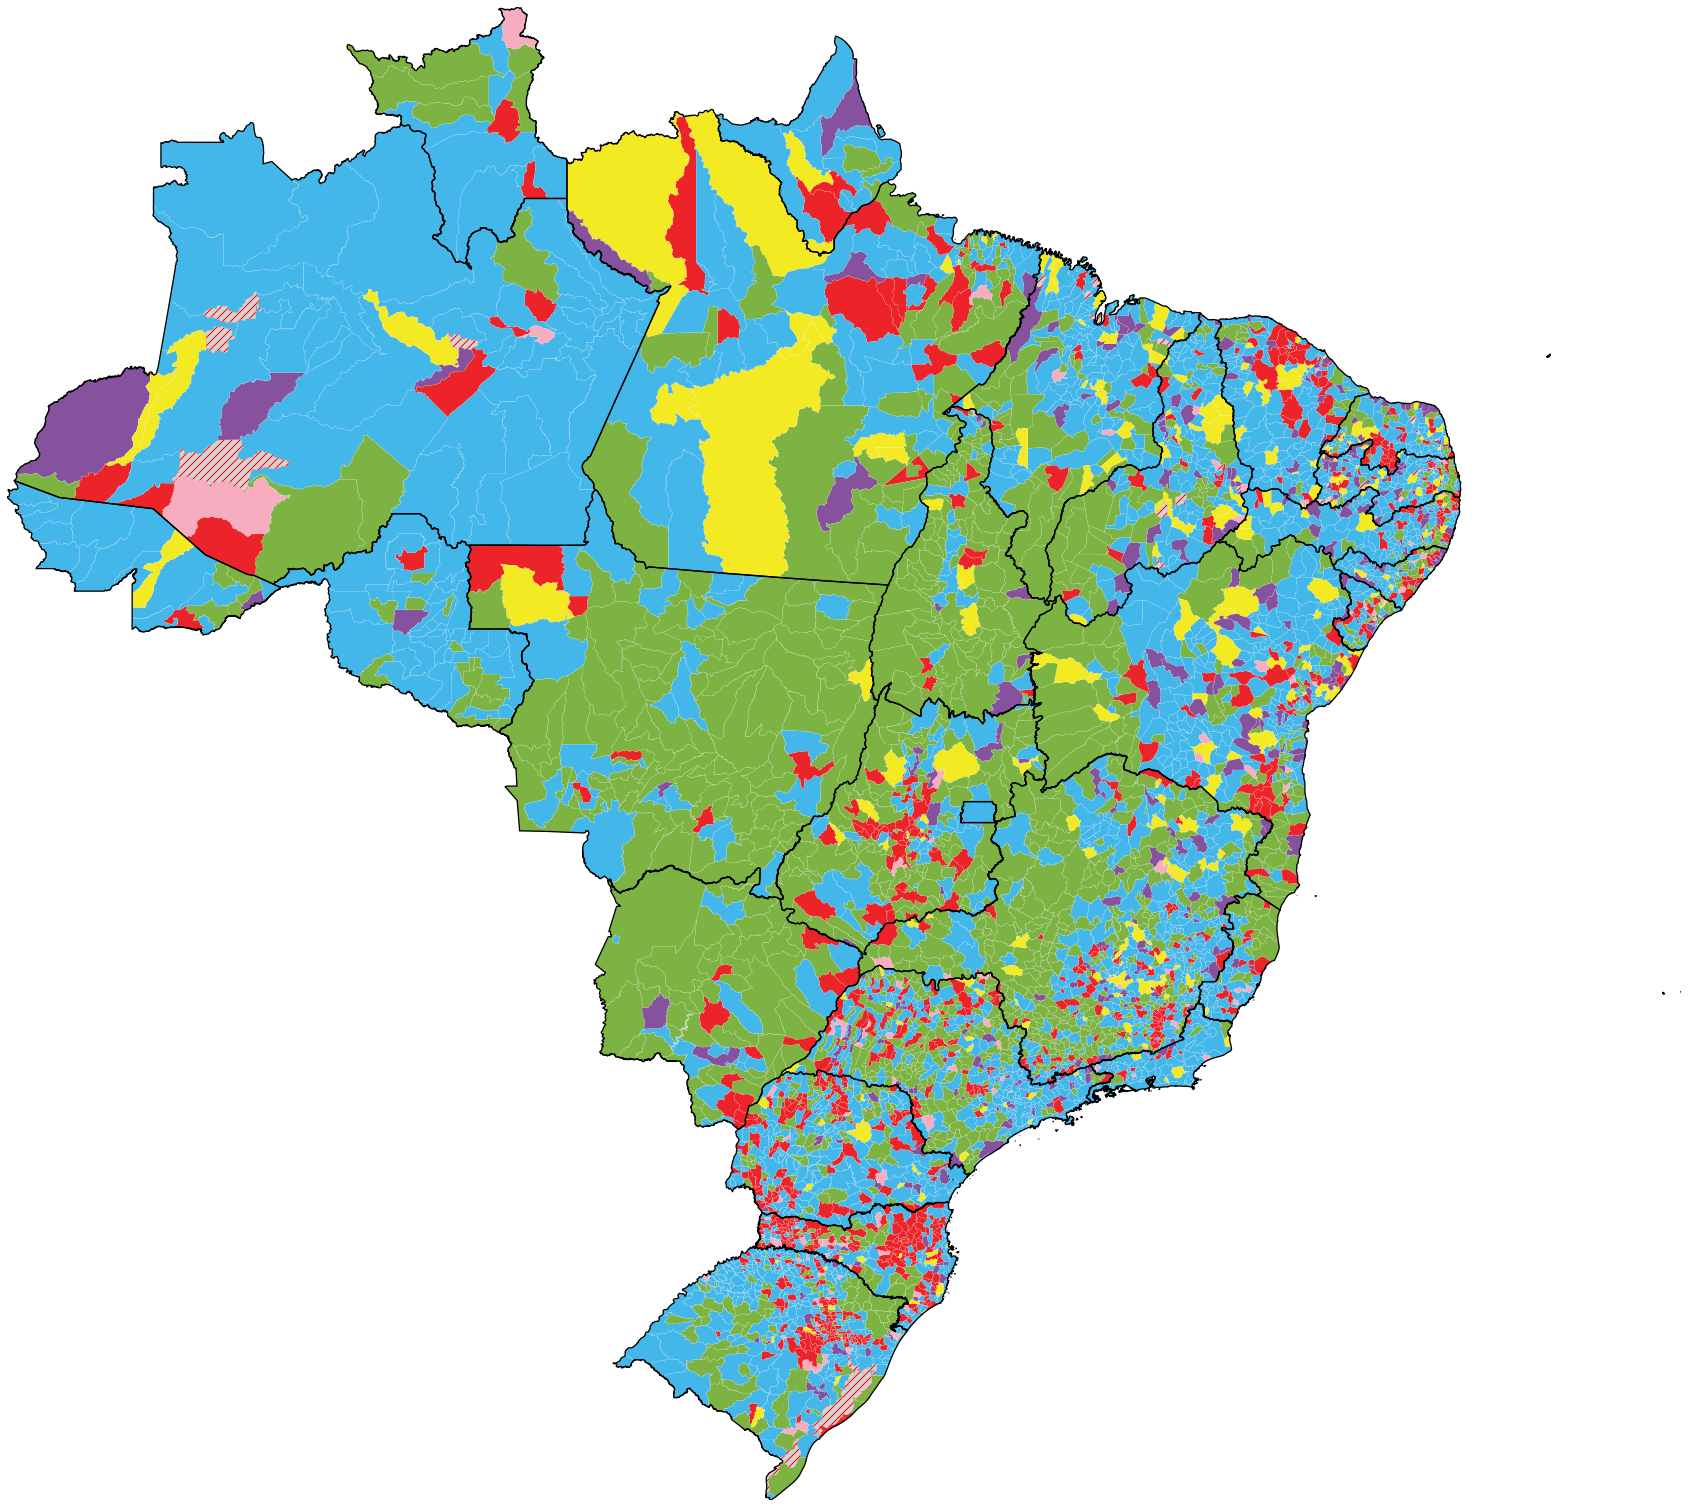

In [5]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot()

colors = [
    "#7cb342",
    "#43B7E9",
    "#F4EA24",
    "#EC2328",
    "#86529E",
    "#F7ACC0",
    
]

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

df.plot(column='divisao_economica',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
        missing_kwds=missing_kwds,
        edgecolor='#FFFFFF',
        linewidth = 0.1
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax1)

ax1.axis('off')
ax1.margins(x=0, y=0)

# plt.savefig('../images/tipos_contratacoes_mapa.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Quantidade de divisoes economicas por municipio em 2019

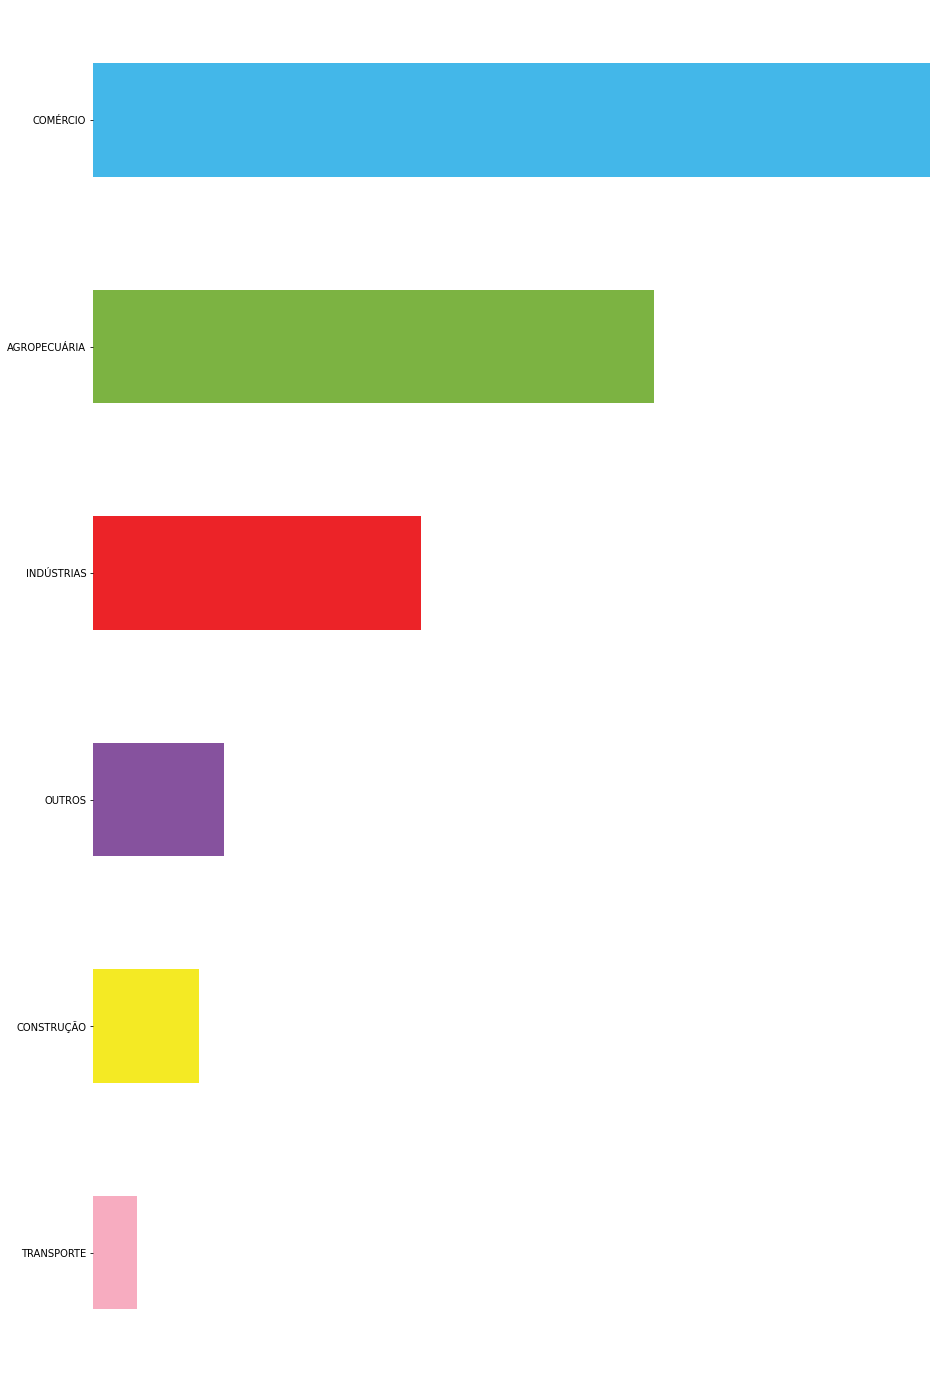

In [6]:
fig = plt.figure(figsize=(15,25))
ax2 = plt.subplot()

px_bar_colors = [
    "#43B7E9",
    "#7cb342",
    "#EC2328",
    "#86529E",
    "#F4EA24",
    "#F7ACC0",
    
]

df_count.plot.barh(
    x='divisao_economica',
    y='count',
    ax=ax2,
    color=px_bar_colors[::-1],
    legend=False
)



ax2.set_ylabel('', fontsize=20)
ax2.axes.get_xaxis().set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.margins(x=0, y=0)

# ax2.set_yticklabels([])
# ax2.set_xticklabels([])

# plt.savefig('../images/tipos_contratacoes_bar.pdf', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Serie temporal divisoes economicas

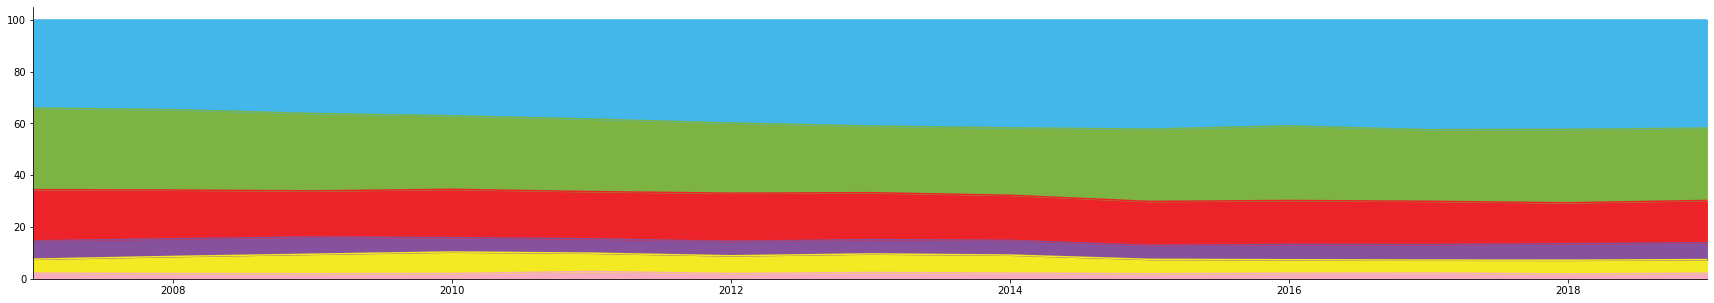

In [7]:

fig = plt.figure(figsize=(30,5))
ax3 = plt.subplot()
px_area_colors = [
    "#F7ACC0",
    "#F4EA24",
    "#86529E",
    "#EC2328",
    "#7cb342",
    "#43B7E9",
]
cols = ['ano', 'TRANSPORTE', 'CONSTRUÇÃO','OUTROS', 'INDÚSTRIAS', 'AGROPECUÁRIA', 'COMÉRCIO']

caged_graph[cols].plot.area(
    x='ano',
    color=px_area_colors,
    ax=ax3,
    legend=False

)
# ax3.set_title('Evolução dos tipos de contratações mais comuns no Brasil', fontsize=32,pad=0,fontweight='bold')

ax3.set_xlabel('', fontsize=22)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.margins(x=0, y=0)
# ax3.set_yticklabels([])
# ax3.set_xticklabels([])


# plt.savefig('../images/tipos_contratacoes_evolucao.pdf', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

# SALARIO

In [8]:
query = """
WITH caged as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    admitidos_desligados,
    salario_mensal
  FROM `basedosdados.br_me_caged.microdados_antigos`
) 

SELECT 
  ano,
  id_municipio,
  sigla_uf,
  AVG(salario_mensal) as media_salario,
  APPROX_QUANTILES(salario_mensal,1000)[OFFSET(500)] as mediana_salario
FROM caged
WHERE admitidos_desligados=1
GROUP BY 1,2,3
"""
caged_salario = bd.read_sql(query, billing_project_id='basedosdados-dev')
caged_salario_2019 = caged_salario[caged_salario['ano']==2019]

Downloading: 100%|██████████| 71321/71321 [00:04<00:00, 15129.24rows/s]


In [9]:
caged_salario_2019
dd = pd.merge(caged_salario_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
dd = gpd.GeoDataFrame(dd).sort_values(by='media_salario', ascending=False)

(-76.24758052685, -26.590708254149995, -35.70232894755, 7.222992030549998)

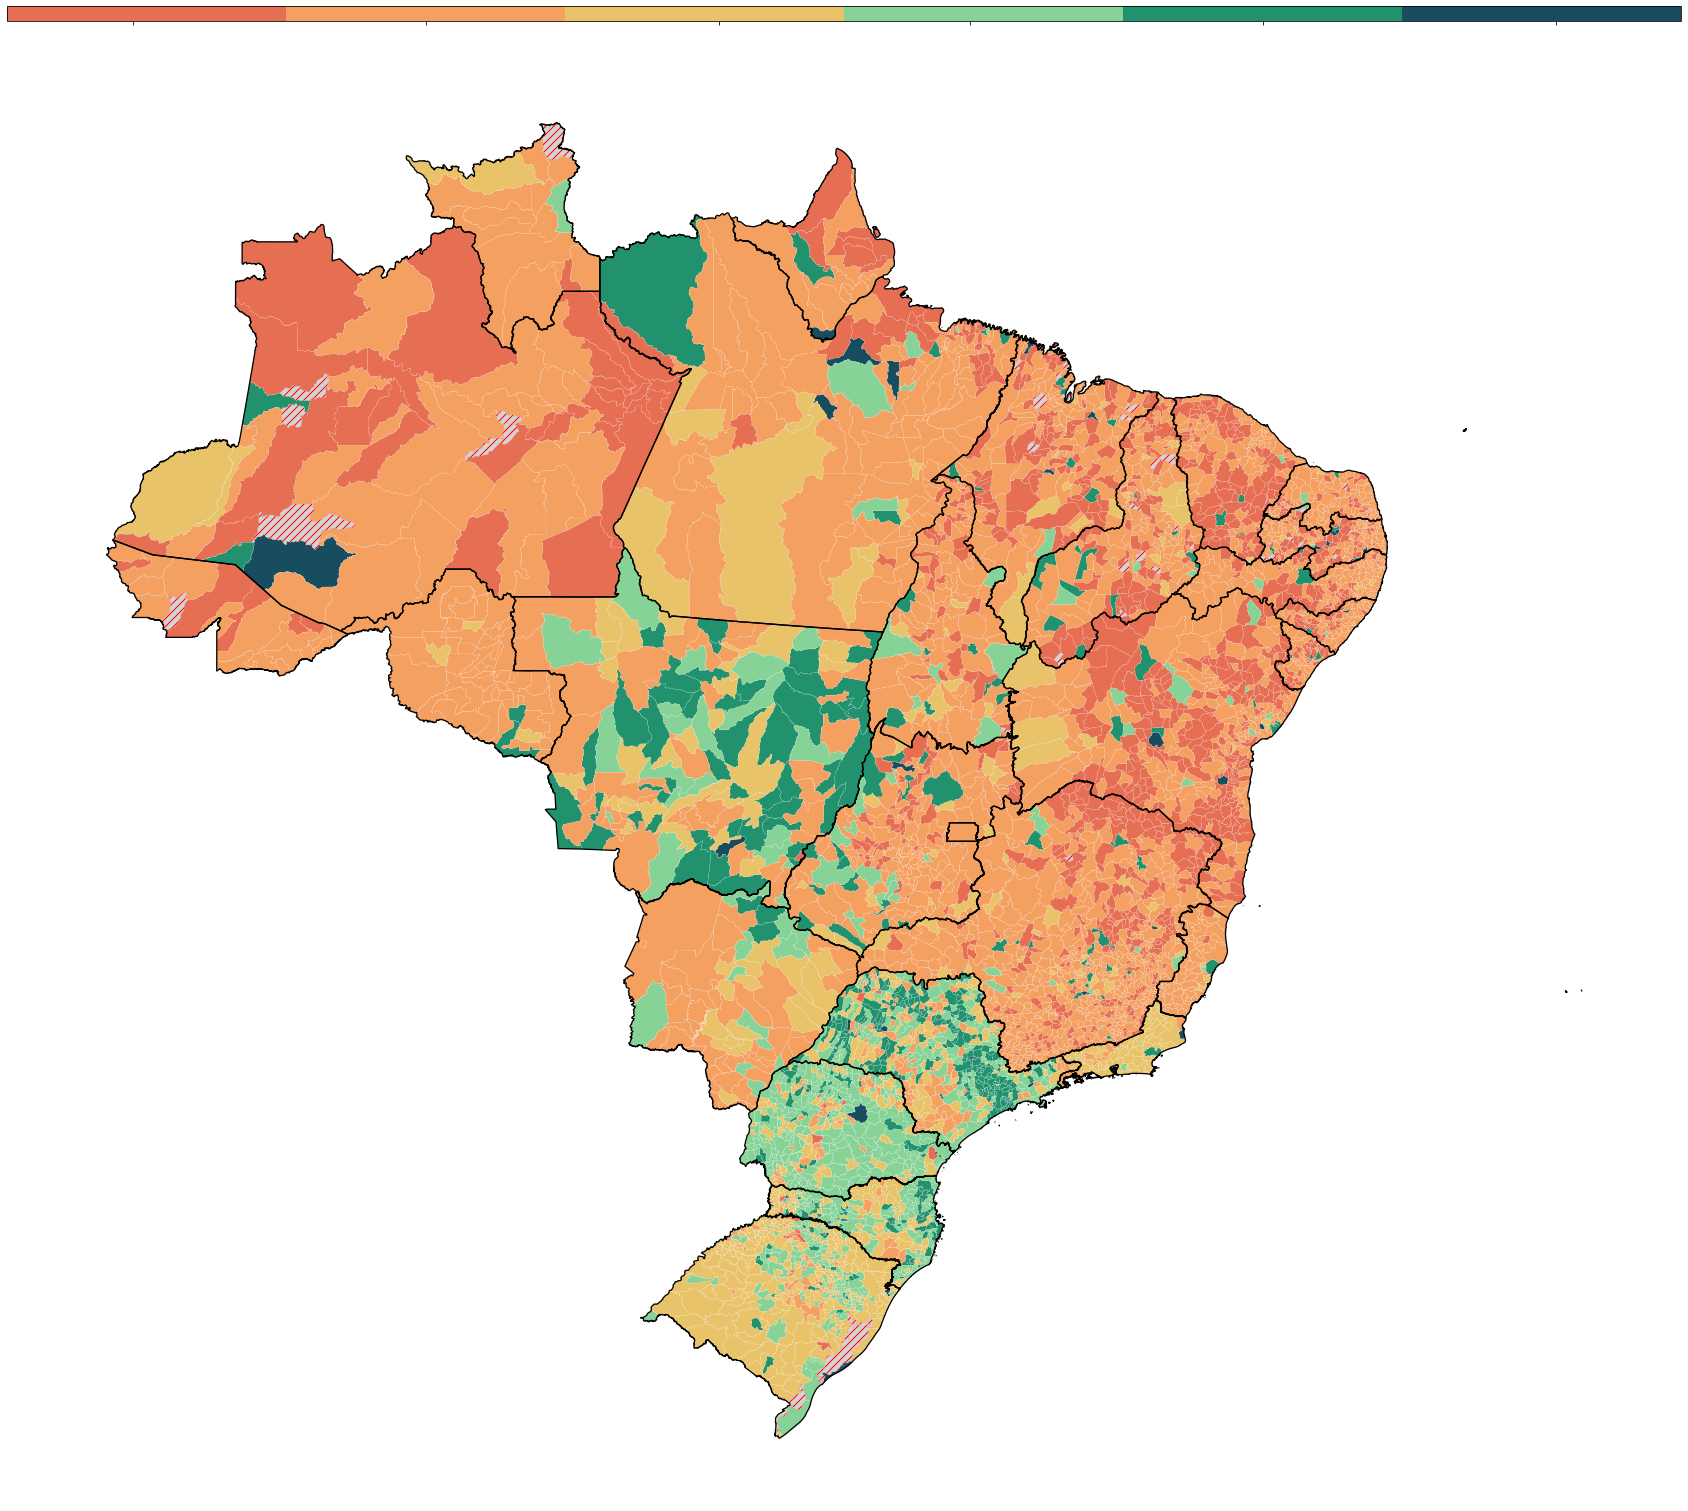

In [10]:
var='mediana_salario'

fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)

colors = [
         "#E66E52",
        "#F3A061",
        "#E8C36A",
        "#87D397",
        "#22926E",
        "#184C5F",
]



cmap = ListedColormap(colors)
colorscale = cmap

divider = make_axes_locatable(ax)
ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
vmax = dd[var].values.max()
vmin = dd[var].values.min()
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
fig.add_axes(ax_cb)
labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
cbar = fig.colorbar(mappable, cax=ax_cb, ticks=labels,orientation='horizontal')
cbar.ax.set_xticklabels([])
cbar.ax.tick_params(labelsize=28) 

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

dd.plot(column=var,
            ax=ax,
    #         legend=True,
#             legend_kwds = legend_kwds,
            cmap=cmap,
            missing_kwds=missing_kwds,
            scheme='user_defined', 
            classification_kwds={'bins':[1000,1200,1300,1400,1800,7200]},
            edgecolor='#FFFFFF',
            linewidth = 0.1
       )

states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)

ax.axis('off')